# Movie recommendation system
Recommender systems are one of the most successful and widespread application of machine learning technologies in business.
You can find large scale recommender systems in retail, video on demand, or music streaming.
- ***Examples of recommendation systems are:***
    1. Offering news articles to on-line newspaper readers, based on a prediction
of reader interests.
    2. Offering customers of an on-line retailer suggestions about what they
might like to buy, based on their past history of purchases and/or product
searches.
    3. Recommending movies to user based on there previous watch 

![](https://md.ekstrandom.net/talks/2014/txstate-recsys-research/movielens.png)

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import random
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import os
from scipy import sparse
from scipy.sparse import csr_matrix
import random
from datetime import datetime
import torch 
import torchvision
from torchvision import datasets
import numpy as np
import time
import numpy
import math
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import MNIST
# Removing Warnings
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Uploading the data and removing the un-necessary columns

In [4]:
movie_user_rating=pd.read_csv('/content/drive/My Drive/Big_Data_Analytics/ml-100k/u.data' ,sep='\t', names=['user_id', 'movie_id', 'rating','timestamp'])
movie_user_rating.timestamp = pd.to_datetime(movie_user_rating.timestamp)
movie_user_rating.sort_values(by=['user_id','timestamp'], inplace=True)

## Calculating the total_users and movies

In [5]:
num_unique_customers=len(pd.unique(movie_user_rating['user_id'])) 
num_unique_movies=len(pd.unique(movie_user_rating['movie_id'])) 

## Test_Data

In [6]:
new_data_for_test=movie_user_rating.sort_values(by="timestamp").drop_duplicates(subset=["user_id"], keep="last")
new_data_for_test.sort_values(by=['user_id','timestamp'], inplace=True)

In [7]:
df = pd.concat([movie_user_rating, new_data_for_test])
new_data_train=df.drop_duplicates(keep=False)

## Removing the unnecessary columns

In [8]:
new_data_train.drop(['rating', 'timestamp'], axis=1,inplace=True)
new_data_for_test.drop(['rating', 'timestamp'], axis=1,inplace=True)

In [24]:
new_data_for_train1=new_data_train.values.tolist()
new_data_for_test1=new_data_for_test.values.tolist()

## Creating Observed List Dictionary

In [10]:
def creating_observed_list(new_data_for_train1):
    
    new_dic_train_observed_interactions=dict()
    for i in range(len(new_data_for_train1)):
        
        if new_data_for_train1[i][0] in new_dic_train_observed_interactions:
            new_dic_train_observed_interactions[new_data_for_train1[i][0]].append(new_data_for_train1[i][1])
        else:
            new_dic_train_observed_interactions[new_data_for_train1[i][0]]=[]
            new_dic_train_observed_interactions[new_data_for_train1[i][0]].append(new_data_for_train1[i][1])
    return new_dic_train_observed_interactions


In [11]:
new_dic_train_observed_interactions=creating_observed_list(new_data_for_train1)

## Creating Unobserved List Dictionary

In [15]:
def creating_unobserved_list(new_dic_train_observed_interactions,num_unique_movies):
    new_unobserved_interactions=dict()
    for i in new_dic_train_observed_interactions.keys():
        list2=[i for i in range(1,num_unique_movies+1)]
        new_unobserved_interactions[i]=np.setdiff1d(list2,new_dic_train_observed_interactions[i])
      
    return new_unobserved_interactions

In [16]:
new_unobserved_interactions = creating_unobserved_list(new_dic_train_observed_interactions,num_unique_movies)

## Creating Training Data for  user , movie and label

In [18]:
def creating_training_data(new_dic_train_observed_interactions,new_unobserved_interactions,num_negatives):
    train_list_user=[]
    train_list_mov=[]
    train_list_label=[]
    for i in new_dic_train_observed_interactions.keys():
        for j in range(len(new_dic_train_observed_interactions[i])):
            train_list_user.append(int(i)-1)
            train_list_mov.append(int(new_dic_train_observed_interactions[i][j]))
            train_list_label.append(1)
            sampling_from_unobserved1=random.sample(list(new_unobserved_interactions[i]), num_negatives)

    for l in range(len(sampling_from_unobserved1)):
        train_list_user.append(int(i)-1)
        train_list_mov.append(int(sampling_from_unobserved1[l]))
        train_list_label.append(0)
  
  return train_list_user, train_list_mov, train_list_label

In [19]:
train_list_user, train_list_mov, train_list_label= creating_training_data(new_dic_train_observed_interactions,new_unobserved_interactions,4)

## Creating Input Data 

In [20]:
input_train_loader1=[]
for j in range(len(train_list_label)):
    input_train_loader1.append([[np.array(train_list_user[j]),np.array(train_list_mov[j]-1)],train_list_label[j]])

In [21]:
train_loader_gmf=torch.utils.data.DataLoader(input_train_loader1, 
                                           batch_size=1024, 
                                           shuffle=True) 
train_loader_mlp=torch.utils.data.DataLoader(input_train_loader1, 
                                           batch_size=256, 
                                           shuffle=True)     

## Creating Test_Data

In [22]:
def creating_test_data(new_data_for_test1,new_unobserved_interactions,num_negatives_to_be_added):
    test_list_user=[]
    test_list_mov=[]
    test_list_label=[]
    num_negatives_to_be_added=100
    for i in range(len(new_data_for_test1)):
        a=new_data_for_test1[i][0]-1
        test_list_user.append(a)
        test_list_mov.append(new_data_for_test1[i][1])
        test_list_label.append(1)
        sampling_from_unobserved1=random.sample(list(new_unobserved_interactions[a+1]), num_negatives_to_be_added)
        for l in range(len(sampling_from_unobserved1)):
            test_list_user.append(a)
            test_list_mov.append(int(sampling_from_unobserved1[l]))
            test_list_label.append(0)
    return test_list_user,test_list_mov,test_list_label

In [26]:
test_list_user,test_list_mov,test_list_label=creating_test_data(new_data_for_test1,new_unobserved_interactions,100)

## Test_Loader

In [27]:
input_test_loader1=[]
for j in range(len(test_list_label)):
      input_test_loader1.append([[np.array(test_list_user[j]),np.array(test_list_mov[j]-1)],test_list_label[j]])

In [28]:
test_loader2=torch.utils.data.DataLoader(input_test_loader1,batch_size=101,shuffle=False)     

## Evaluation Function: Hit_Ratio and NDCG

In [29]:
def func_Hit_Ratio1(model,test_loader,K):
    model.eval()
    a=0
    NDCG=[]
    with torch.no_grad():
        for i ,(user,label) in enumerate(test_loader):
            user1= user[0].type(torch.LongTensor)
            movie1=user[1].type(torch.LongTensor)
            labels1= label.float()
            outputs= model(user1,movie1).cuda()
            flattened_output=torch.flatten(outputs)
            indices=torch.topk(flattened_output, K).indices
            labels_new=labels1[indices]
            if torch.sum(labels_new) > 0 :
                step1=labels_new.numpy()
                step2=np.where(step1 == 1)[0][0]
                ndcg=math.log(2) / math.log(step2+2)
            else:
                ndcg=0
            NDCG.append(ndcg)
            a=a+torch.sum(labels_new)
  
    return a/(i+1) ,np.mean(NDCG)

## Generalized Matrix Factorization

In [30]:
class GMF1(nn.Module):
    def __init__(self, user_size,latent_dimension,unique_movies):
        super(GMF1, self).__init__()
        self.embeddings = torch.nn.Embedding(user_size, latent_dimension)
        self.fc1 = torch.nn.Embedding(unique_movies,latent_dimension)
        self.fc2=nn.Linear(latent_dimension,1)
        self.act=nn.Sigmoid()    
    
    def forward(self, user, movie):
        self.output1= self.embeddings(user)
        self.output2=self.fc1(movie)
        element_product = torch.mul(self.output1, self.output2)
        self.output3=self.act(self.fc2(element_product))
       
        return self.output3

## Neural Collaborative Filtering

In [31]:
class MLP1(nn.Module):
    def __init__(self, user_size,layer_size,movie_size):#[32,64,32,16,8]
        super(MLP1, self).__init__()
        self.embeddings_user = torch.nn.Embedding(user_size, int(layer_size[0]/2))
        torch.nn.init.kaiming_normal_(self.embeddings_user.weight)
        self.embedding_item = torch.nn.Embedding(movie_size, int(layer_size[0]/2))
        torch.nn.init.kaiming_normal_(self.embedding_item.weight)
        self.forward_layers=[]
        self.act=nn.Sigmoid()
        self.act1=nn.ReLU() 
        for i in range (len(layer_size)-1):
            self.forward_layers.append(nn.Linear(layer_size[i],layer_size[i+1]))
            self.forward_layers.append(self.act1)
        self.layers=nn.Sequential(*self.forward_layers)
        self.affine=nn.Linear(layer_size[len(layer_size)-1],1)
        torch.nn.init.kaiming_normal_(self.affine.weight)

        self.act=nn.Sigmoid()
        self.act1=nn.ReLU() 
 
    
    def forward(self, user, movie):
        self.output1= self.embeddings_user(user)
        self.output2=self.embedding_item(movie)
        self.output3=torch.cat((self.output1, self.output2), 1)
        self.output3= self.layers(self.output3)
        # for i in range(len(self.forward_layers)):
        #   self.output3= self.act1(self.forward_layers[i](self.output3))
        self.output4= self.act(self.affine(self.output3))
        return self.output4

## Neural Matrix Factorization Model

In [32]:
class NCF(nn.Module):
    def __init__(self, user_size,layer_size,movie_size,mf_embedding_size):
        super(NCF, self).__init__()
        self.embeddings_user_MF = torch.nn.Embedding(user_size, int(mf_embedding_size))
        self.embeddings_item_MF = torch.nn.Embedding(movie_size, mf_embedding_size)
        self.embeddings_user_MLP = torch.nn.Embedding(user_size, int(layer_size[0]/2))
        self.embeddings_item_MLP = torch.nn.Embedding(movie_size, int(layer_size[0]/2))

        torch.nn.init.kaiming_normal_(self.embeddings_user_MF.weight)
        torch.nn.init.kaiming_normal_(self.embeddings_item_MF.weight)
        torch.nn.init.kaiming_normal_(self.embeddings_user_MLP.weight)
        torch.nn.init.kaiming_normal_(self.embeddings_item_MLP.weight)
        self.act1=nn.ReLU() 
        self.forward_layers=[]
        for i in range (len(layer_size)-1):
            self.forward_layers.append( nn.Linear(layer_size[i],layer_size[i+1]))
            self.forward_layers.append(self.act1)
        
        self.layers=nn.Sequential(*self.forward_layers)
        self.affine=nn.Linear(layer_size[len(layer_size)-1]+mf_embedding_size,1)
        torch.nn.init.kaiming_normal_(self.affine.weight)

        self.act=nn.Sigmoid()
     
  
    
    def forward(self, user, movie):
        self.output_user_MF= self.embeddings_user_MF(user)
        self.output_user_MLP= self.embeddings_user_MLP(user)
        self.output_item_MF= self.embeddings_item_MF(movie)
        self.output_item_MLP= self.embeddings_item_MLP(movie)

        self.element_product_MF = torch.mul(self.output_user_MF,self.output_item_MF)
        self.element_concat=torch.cat((self.output_user_MLP, self.output_item_MLP), 1)
        self.element_concat= self.layers(self.element_concat)

        self.output6= torch.cat((self.element_product_MF,self.element_concat),1)
        self.output7= self.act(self.affine(self.output6))
        return self.output7

## Main_Function

In [33]:
def func_for_cal1(model,train_loader,learning_rate,test_loader,K1,weightdecay):
    plot_loss=[]
    Hit_Ratio=[]
    Ndcg_ratio=[]
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weightdecay)
    for epoch in range(100):
        new_loss=0
        for j ,(outputs,labels) in enumerate(train_loader):
            model.train()
            user1= outputs[0].type(torch.LongTensor)
            movie1=outputs[1].type(torch.LongTensor)
            labels1= labels.float()

            optimizer.zero_grad()
            outputs2=model(user1,movie1)

            outputs3=torch.flatten(outputs2).float()
            loss = criterion(outputs3,labels1)
            loss.backward()
            optimizer.step()
            new_loss=new_loss+loss.item()
    
    values_Hit,Ndcg_values=func_Hit_Ratio1(model,test_loader,K1)
    Hit_Ratio.append(values_Hit.cpu().numpy())
    Ndcg_ratio.append(Ndcg_values)
    plot_loss.append(new_loss/j)
    if epoch%20==0:
        print('Iteration: {}. Trainining_Loss: {}.Hit_Ratio:{}.NDCG_Ratio:{}'.format(epoch, new_loss/j,values_Hit.cpu().numpy(),Ndcg_values))
  
    return Hit_Ratio,Ndcg_ratio,plot_loss

## Generalised Matrix Factorization (GMF)

#### GMF with Embedding_size 8

In [ ]:
model_Gmf_8_001=GMF1(num_unique_customers,8,num_unique_movies)
gmf_8_001=func_for_cal1(model_Gmf_8_001,train_loader_gmf,0.001,test_loader2,10,0)
filename='/content/drive/My Drive/Big_Data_Analytics/gmf_8_001.p'
filename_weights='/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p'
pickle.dump(gmf_8_001, open(filename, 'wb'))
pickle.dump(model_Gmf_8_001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.6118994583501085.Hit_Ratio:0.10074231028556824.NDCG_Ratio:0.04713444681852313
Iteration: 20. Trainining_Loss: 0.3464846814641301.Hit_Ratio:0.3828207850456238.NDCG_Ratio:0.2050161018539703
Iteration: 40. Trainining_Loss: 0.2764407474678742.Hit_Ratio:0.5524920225143433.NDCG_Ratio:0.3087314322434312
Iteration: 60. Trainining_Loss: 0.25339304317968975.Hit_Ratio:0.5959703326225281.NDCG_Ratio:0.33093075581676346
Iteration: 80. Trainining_Loss: 0.241018619719993.Hit_Ratio:0.6076352000236511.NDCG_Ratio:0.34153211010355455


#### GMF with Embedding_size 16

In [ ]:
model_Gmf_16_001=GMF1(num_unique_customers,16,num_unique_movies)
gmf_16_001=func_for_cal1(model_Gmf_16_001,train_loader_gmf,0.001,test_loader2,10,0)
filename='/content/drive/My Drive/Big_Data_Analytics/gmf_16_001.p'
filename_weights='/content/drive/My Drive/Big_Data_Analytics/gmf_16_001_weights.p'
pickle.dump(gmf_16_001, open(filename, 'wb'))
pickle.dump(model_Gmf_16_001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.6622851620549741.Hit_Ratio:0.11346765607595444.NDCG_Ratio:0.05265726508554413
Iteration: 20. Trainining_Loss: 0.3219380687852824.Hit_Ratio:0.4231176972389221.NDCG_Ratio:0.2301881153210793
Iteration: 40. Trainining_Loss: 0.2495905898249174.Hit_Ratio:0.5461293458938599.NDCG_Ratio:0.30055697084989613
Iteration: 60. Trainining_Loss: 0.21980481627194778.Hit_Ratio:0.5779427289962769.NDCG_Ratio:0.31717612299634396
Iteration: 80. Trainining_Loss: 0.20433098716395243.Hit_Ratio:0.5853658318519592.NDCG_Ratio:0.32271868866321607


## Neural Collaborative Filtering (Randomly Initialised)

`#### NCF with architecture [16,32,16,8] and 0.00001 (regularisation coefficient)`

In [ ]:
model_MLP_8_001_arch1_00001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
mlp_8_001_arch1_00001=func_for_cal1(model_MLP_8_001_arch1_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_00001.p'
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_00001_weights.p'
pickle.dump(mlp_8_001_arch1_00001,open(filename, 'wb'))
pickle.dump(model_MLP_8_001_arch1_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.4223958989672725.Hit_Ratio:0.3976670205593109.NDCG_Ratio:0.2076309724768876
Iteration: 20. Trainining_Loss: 0.2749151148772659.Hit_Ratio:0.5673382878303528.NDCG_Ratio:0.3201961672105643
Iteration: 40. Trainining_Loss: 0.25667039091547617.Hit_Ratio:0.5758218169212341.NDCG_Ratio:0.31543322548922964
Iteration: 60. Trainining_Loss: 0.24866153653460674.Hit_Ratio:0.5758218169212341.NDCG_Ratio:0.32406610092396504
Iteration: 80. Trainining_Loss: 0.24364625409075985.Hit_Ratio:0.5694591999053955.NDCG_Ratio:0.3186870942793214


#### NCF with architecture [16,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch1_0001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
mlp_8_001_arch1_0001=func_for_cal1(model_MLP_8_001_arch1_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_0001.p'
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_0001_weights.p'
pickle.dump(mlp_8_001_arch1_0001,open(filename, 'wb'))
pickle.dump(model_MLP_8_001_arch1_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.413166600829443.Hit_Ratio:0.38706257939338684.NDCG_Ratio:0.20611270049526595
Iteration: 20. Trainining_Loss: 0.260028480782319.Hit_Ratio:0.5991516709327698.NDCG_Ratio:0.3436578952913419
Iteration: 40. Trainining_Loss: 0.2467944642303525.Hit_Ratio:0.6065747737884521.NDCG_Ratio:0.3526587234988717
Iteration: 60. Trainining_Loss: 0.24358753078725986.Hit_Ratio:0.6203605532646179.NDCG_Ratio:0.3509520167070088
Iteration: 80. Trainining_Loss: 0.24235154049627045.Hit_Ratio:0.6118769645690918.NDCG_Ratio:0.3481866221443455


#### NCF with architecture [16,32,16,8] and 0.001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch1_001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
mlp_8_001_arch1_001=func_for_cal1(model_MLP_8_001_arch1_001,train_loader_mlp,0.001,test_loader2,10,0.001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_001.p'
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_001_weights.p'
pickle.dump(mlp_8_001_arch1_001,open(filename, 'wb'))
pickle.dump(model_MLP_8_001_arch1_001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.4271717648933937.Hit_Ratio:0.3913043439388275.NDCG_Ratio:0.21119073874721028
Iteration: 20. Trainining_Loss: 0.2942110303454217.Hit_Ratio:0.5726405382156372.NDCG_Ratio:0.3188841170574024
Iteration: 40. Trainining_Loss: 0.2871549067770313.Hit_Ratio:0.5790031552314758.NDCG_Ratio:0.3214601199466068
Iteration: 60. Trainining_Loss: 0.28340930934714187.Hit_Ratio:0.5949098467826843.NDCG_Ratio:0.3350731320327609
Iteration: 80. Trainining_Loss: 0.28273531126538376.Hit_Ratio:0.5906680822372437.NDCG_Ratio:0.3372261037782238


#### NCF with architecture [16,64,32,16,8] and 0.00001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_00001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
mlp_8_001_arch2_00001=func_for_cal1(model_MLP_8_001_arch2_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_00001.p'
pickle.dump(mlp_8_001_arch2_00001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_00001_weights.p'
pickle.dump(model_MLP_8_001_arch2_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.4075886583131003.Hit_Ratio:0.39660656452178955.NDCG_Ratio:0.21131526647550716
Iteration: 20. Trainining_Loss: 0.2709302282290227.Hit_Ratio:0.5811240673065186.NDCG_Ratio:0.32775910274460474
Iteration: 40. Trainining_Loss: 0.2507473119643383.Hit_Ratio:0.5630965232849121.NDCG_Ratio:0.32112911736304345
Iteration: 60. Trainining_Loss: 0.24247653055801263.Hit_Ratio:0.5715800523757935.NDCG_Ratio:0.3229762636374683
Iteration: 80. Trainining_Loss: 0.23762469789573792.Hit_Ratio:0.555673360824585.NDCG_Ratio:0.30931513253549486


#### NCF with architecture [16,64,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_0001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
mlp_8_001_arch2_0001=func_for_cal1(model_MLP_8_001_arch2_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_0001.p'
pickle.dump(mlp_8_001_arch2_0001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_0001_weights.p'
pickle.dump(model_MLP_8_001_arch2_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.40528036381244165.Hit_Ratio:0.4008483588695526.NDCG_Ratio:0.21798537822788175
Iteration: 20. Trainining_Loss: 0.2525287324248697.Hit_Ratio:0.6150583028793335.NDCG_Ratio:0.35138003405007756
Iteration: 40. Trainining_Loss: 0.24332202659706048.Hit_Ratio:0.6076352000236511.NDCG_Ratio:0.3412845649170282
Iteration: 60. Trainining_Loss: 0.2400946950206712.Hit_Ratio:0.6256628036499023.NDCG_Ratio:0.35432621087267385
Iteration: 80. Trainining_Loss: 0.23846072917024008.Hit_Ratio:0.6171792149543762.NDCG_Ratio:0.35011086435987226


#### NCF with architecture [16,64,32,16,8] and 0.001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
mlp_8_001_arch2_001=func_for_cal1(model_MLP_8_001_arch2_0001,train_loader_mlp,0.001,test_loader2,10,0.001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_001.p'
pickle.dump(mlp_8_001_arch2_001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_001_weights.p'
pickle.dump(model_MLP_8_001_arch2_001.state_dict(),open(filename_weights, 'wb'))

## Neural Collaborative Filtering with weights pretrained from GMF

#### NCF with architecture [16,64,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_pretrained_0001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
model_MLP_8_001_arch2_pretrained_0001.embeddings_user.weight.data =model_Gmf_8_001.embeddings.weight.data
model_MLP_8_001_arch2_pretrained_0001.embedding_item.weight.data = model_Gmf_8_001.fc1.weight.data
mlp_8_001_arch2_pretrained_0001=func_for_cal1(model_MLP_8_001_arch2_pretrained_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_0001.p'
pickle.dump(mlp_8_001_arch2_pretrained_0001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_0001_weights.p'
pickle.dump(model_MLP_8_001_arch2_pretrained_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.278802113370602.Hit_Ratio:0.6033934354782104.NDCG_Ratio:0.3344447585647691
Iteration: 20. Trainining_Loss: 0.24063580788309843.Hit_Ratio:0.6373276710510254.NDCG_Ratio:0.36208467558012863
Iteration: 40. Trainining_Loss: 0.23862791311038195.Hit_Ratio:0.6341463327407837.NDCG_Ratio:0.361723293563525
Iteration: 60. Trainining_Loss: 0.23691579983824904.Hit_Ratio:0.6341463327407837.NDCG_Ratio:0.36075152526445864
Iteration: 80. Trainining_Loss: 0.2354578903829053.Hit_Ratio:0.6373276710510254.NDCG_Ratio:0.3619738340502703


#### NCF with architecture [16,64,32,16,8] and 0.00001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_pretrained_00001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
model_MLP_8_001_arch2_pretrained_00001.embeddings_user.weight.data =weights_gmf['embeddings.weight']
model_MLP_8_001_arch2_pretrained_00001.embedding_item.weight.data = weights_gmf['fc1.weight']
mlp_8_001_arch2_pretrained_00001=func_for_cal1(model_MLP_8_001_arch2_pretrained_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_00001.p'
pickle.dump(mlp_8_001_arch2_pretrained_00001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_00001_weights.p'
pickle.dump(model_MLP_8_001_arch2_pretrained_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.28917506406509397.Hit_Ratio:0.619300127029419.NDCG_Ratio:0.3415985062818547
Iteration: 20. Trainining_Loss: 0.22719293926777984.Hit_Ratio:0.628844141960144.NDCG_Ratio:0.3576408112236844
Iteration: 40. Trainining_Loss: 0.22127702446209485.Hit_Ratio:0.6203605532646179.NDCG_Ratio:0.35532175785016246
Iteration: 60. Trainining_Loss: 0.2170962713689629.Hit_Ratio:0.6097561120986938.NDCG_Ratio:0.35043500819610907
Iteration: 80. Trainining_Loss: 0.2140549302116545.Hit_Ratio:0.5959703326225281.NDCG_Ratio:0.3327592990522276


#### NCF with architecture [16,64,32,16,8] and 0.001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch2_pretrained_001=MLP1(num_unique_customers,[16,64,32,16,8],num_unique_movies)
model_MLP_8_001_arch2_pretrained_001.embeddings_user.weight.data =model_Gmf_8_001.embeddings.weight.data
model_MLP_8_001_arch2_pretrained_001.embedding_item.weight.data = model_Gmf_8_001.fc1.weight.data
mlp_8_001_arch2_pretrained_001=func_for_cal1(model_MLP_8_001_arch2_pretrained_001,train_loader_mlp,0.001,test_loader2,10,0.001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_001.p'
pickle.dump(mlp_8_001_arch2_pretrained_001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_001_weights.p'
pickle.dump(model_MLP_8_001_arch2_pretrained_001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.3814409418646034.Hit_Ratio:0.3987274765968323.NDCG_Ratio:0.2175406541336271
Iteration: 20. Trainining_Loss: 0.286918309198417.Hit_Ratio:0.6023330092430115.NDCG_Ratio:0.348615603611913
Iteration: 40. Trainining_Loss: 0.2788121374680313.Hit_Ratio:0.5991516709327698.NDCG_Ratio:0.3434310185173533
Iteration: 60. Trainining_Loss: 0.2762122996683081.Hit_Ratio:0.6044538617134094.NDCG_Ratio:0.3449300474174114
Iteration: 80. Trainining_Loss: 0.2756097704526557.Hit_Ratio:0.6108165383338928.NDCG_Ratio:0.34458943504630624


#### NCF with architecture [16,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch1_pretrained_0001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
model_MLP_8_001_arch1_pretrained_0001.embeddings_user.weight.data =model_Gmf_8_001.embeddings.weight.data
model_MLP_8_001_arch1_pretrained_0001.embedding_item.weight.data = model_Gmf_8_001.fc1.weight.data
mlp_8_001_arch1_pretrained_0001=func_for_cal1(model_MLP_8_001_arch1_pretrained_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_0001.p'
pickle.dump(mlp_8_001_arch1_pretrained_0001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_0001_weights.p'
pickle.dump(model_MLP_8_001_arch1_pretrained_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.388959455021658.Hit_Ratio:0.3987274765968323.NDCG_Ratio:0.21705338815391806
Iteration: 20. Trainining_Loss: 0.2560030639772578.Hit_Ratio:0.629904568195343.NDCG_Ratio:0.3570693262177053
Iteration: 40. Trainining_Loss: 0.24576887631675204.Hit_Ratio:0.6362672448158264.NDCG_Ratio:0.36334191322779313
Iteration: 60. Trainining_Loss: 0.24272468916478546.Hit_Ratio:0.6203605532646179.NDCG_Ratio:0.3603977894516264
Iteration: 80. Trainining_Loss: 0.2413517994480641.Hit_Ratio:0.630964994430542.NDCG_Ratio:0.35978007315072774


#### NCF with architecture [16,32,16,8] and 0.001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch1_pretrained_001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
model_MLP_8_001_arch1_pretrained_001.embeddings_user.weight.data =model_Gmf_8_001.embeddings.weight.data
model_MLP_8_001_arch1_pretrained_001.embedding_item.weight.data = model_Gmf_8_001.fc1.weight.data
mlp_8_001_arch1_pretrained_001=func_for_cal1(model_MLP_8_001_arch1_pretrained_0001,train_loader_mlp,0.001,test_loader2,10,0.001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_001.p'
pickle.dump(mlp_8_001_arch1_pretrained_001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_001_weights.p'
pickle.dump(model_MLP_8_001_arch1_pretrained_001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.2567447548368108.Hit_Ratio:0.6277836561203003.NDCG_Ratio:0.35127279016011587
Iteration: 20. Trainining_Loss: 0.27310185422571887.Hit_Ratio:0.619300127029419.NDCG_Ratio:0.34264767192256634
Iteration: 40. Trainining_Loss: 0.27196495036951884.Hit_Ratio:0.6182396411895752.NDCG_Ratio:0.34493281495966344
Iteration: 60. Trainining_Loss: 0.2718765052823271.Hit_Ratio:0.6065747737884521.NDCG_Ratio:0.343154864820127
Iteration: 80. Trainining_Loss: 0.2713321139255872.Hit_Ratio:0.6182396411895752.NDCG_Ratio:0.35047760479136486


#### NCF with architecture [16,32,16,8] and 0.001 (regularisation coefficient)

In [ ]:
model_MLP_8_001_arch1_pretrained_00001=MLP1(num_unique_customers,[16,32,16,8],num_unique_movies)
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
model_MLP_8_001_arch1_pretrained_00001.embeddings_user.weight.data =weights_gmf['embeddings.weight']
model_MLP_8_001_arch1_pretrained_00001.embedding_item.weight.data = weights_gmf['fc1.weight']
mlp_8_001_arch1_pretrained_00001=func_for_cal1(model_MLP_8_001_arch1_pretrained_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_00001.p'
pickle.dump(mlp_8_001_arch1_pretrained_00001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_00001_weights.p'
pickle.dump(model_MLP_8_001_arch1_pretrained_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.2899509658102782.Hit_Ratio:0.6097561120986938.NDCG_Ratio:0.3383569819026751
Iteration: 20. Trainining_Loss: 0.23018772394666998.Hit_Ratio:0.6129374504089355.NDCG_Ratio:0.3603191792601268
Iteration: 40. Trainining_Loss: 0.22546755836076549.Hit_Ratio:0.6267232298851013.NDCG_Ratio:0.35501141594215413
Iteration: 60. Trainining_Loss: 0.22300640922790968.Hit_Ratio:0.6161187887191772.NDCG_Ratio:0.34688378376933227
Iteration: 80. Trainining_Loss: 0.220901045875071.Hit_Ratio:0.6171792149543762.NDCG_Ratio:0.3399337854816993


## Neural Matrix Factorization Model (NMF)

#### NMF with architecture [16,32,16,8] and 0.0001(regularisation coefficient).

In [ ]:
model_ncf_arch1_0001= NCF(num_unique_customers,[16,32,16,8],num_unique_movies,8)
ncf_arch1_0001=func_for_cal1(model_ncf_arch1_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_0001.p'
pickle.dump(ncf_arch1_0001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_0001_weights.p'
pickle.dump(model_ncf_arch1_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.4228978384028053.Hit_Ratio:0.39978790283203125.NDCG_Ratio:0.20929210797296546
Iteration: 20. Trainining_Loss: 0.2614084407378994.Hit_Ratio:0.6161187887191772.NDCG_Ratio:0.35059536794174245
Iteration: 40. Trainining_Loss: 0.2472579283899827.Hit_Ratio:0.6161187887191772.NDCG_Ratio:0.34774420728705435
Iteration: 60. Trainining_Loss: 0.24428890068411457.Hit_Ratio:0.6044538617134094.NDCG_Ratio:0.34510933732259336
Iteration: 80. Trainining_Loss: 0.24235371552646592.Hit_Ratio:0.619300127029419.NDCG_Ratio:0.35628023174839557


#### NMF with architecture [16,32,16,8] and 0.00001(regularisation coefficient).

In [ ]:
model_ncf_arch1_00001= NCF(num_unique_customers,[16,32,16,8],num_unique_movies,8)
ncf_arch1_00001=func_for_cal1(model_ncf_arch1_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_00001.p'
pickle.dump(ncf_arch1_00001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_00001_weights.p'
pickle.dump(model_ncf_arch1_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.41024332391069246.Hit_Ratio:0.39342522621154785.NDCG_Ratio:0.2037564197553864
Iteration: 20. Trainining_Loss: 0.26292426963534204.Hit_Ratio:0.5705196261405945.NDCG_Ratio:0.3225488555045764
Iteration: 40. Trainining_Loss: 0.23730792542832838.Hit_Ratio:0.598091185092926.NDCG_Ratio:0.3299941222490247
Iteration: 60. Trainining_Loss: 0.2288629096829657.Hit_Ratio:0.5843054056167603.NDCG_Ratio:0.3221860933877608
Iteration: 80. Trainining_Loss: 0.22483894417703829.Hit_Ratio:0.5938494205474854.NDCG_Ratio:0.32137371803610837


#### NMF with architecture [16,64,32,16,8] and 0.0001(regularisation coefficient).

In [ ]:
model_ncf_arch2_0001= NCF(num_unique_customers,[16,64,32,16,8],num_unique_movies,8)
ncf_arch2_0001=func_for_cal1(model_ncf_arch2_0001,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_0001.p'
pickle.dump(ncf_arch2_0001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_0001_weights.p'
pickle.dump(model_ncf_arch2_0001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.4040807069519067.Hit_Ratio:0.4008483588695526.NDCG_Ratio:0.21319193417915672
Iteration: 20. Trainining_Loss: 0.2537138408286865.Hit_Ratio:0.6235418915748596.NDCG_Ratio:0.3545690052178858
Iteration: 40. Trainining_Loss: 0.24370348406522202.Hit_Ratio:0.6341463327407837.NDCG_Ratio:0.36304208610742084
Iteration: 60. Trainining_Loss: 0.24043235133451168.Hit_Ratio:0.6086956262588501.NDCG_Ratio:0.35060184014735496
Iteration: 80. Trainining_Loss: 0.23830290468488632.Hit_Ratio:0.6139978766441345.NDCG_Ratio:0.3535004572832833


#### NMF with architecture [16,64,32,16,8] and 0.00001(regularisation coefficient).

In [ ]:
model_ncf_arch2_00001= NCF(num_unique_customers,[16,64,32,16,8],num_unique_movies,8)
ncf_arch2_00001=func_for_cal1(model_ncf_arch2_00001,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_00001.p'
pickle.dump(ncf_arch2_00001,open(filename, 'wb'))
filename_weights='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_00001_weights.p'
pickle.dump(model_ncf_arch2_00001.state_dict(),open(filename_weights, 'wb'))

Iteration: 0. Trainining_Loss: 0.41166728294253224.Hit_Ratio:0.3976670205593109.NDCG_Ratio:0.20977908295748265
Iteration: 20. Trainining_Loss: 0.21642799592252354.Hit_Ratio:0.6362672448158264.NDCG_Ratio:0.3620442853194035
Iteration: 40. Trainining_Loss: 0.19516350912949168.Hit_Ratio:0.6246023178100586.NDCG_Ratio:0.3530639347815395
Iteration: 60. Trainining_Loss: 0.18574468251760767.Hit_Ratio:0.6002120971679688.NDCG_Ratio:0.3425520528506664
Iteration: 80. Trainining_Loss: 0.18079252497147627.Hit_Ratio:0.5896076560020447.NDCG_Ratio:0.3348341823840371


## NCF with pretraining from GMF and MLP

#### NCF pretraining with [16,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_ncf_arch1_0001_pretrained= NCF(num_unique_customers,[16,32,16,8],num_unique_movies,8)
## Downloading weights from the file:
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
weights_mlp=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_0001_weights.p',"rb"))

model_ncf_arch1_0001_pretrained.embeddings_user_MF.weight.data =weights_gmf['embeddings.weight']
model_ncf_arch1_0001_pretrained.embeddings_item_MF.weight.data = weights_gmf['fc1.weight']
model_ncf_arch1_0001_pretrained.embeddings_user_MLP .weight.data = weights_mlp['embeddings_user.weight']
model_ncf_arch1_0001_pretrained.embeddings_item_MLP.weight.data = weights_mlp['embedding_item.weight']
model_ncf_arch1_0001_pretrained.forward_layers[0].weight.data=weights_mlp['layers.0.weight']
model_ncf_arch1_0001_pretrained.forward_layers[0].bias.data=weights_mlp['layers.0.bias']
model_ncf_arch1_0001_pretrained.forward_layers[2].weight.data=weights_mlp['layers.2.weight']
model_ncf_arch1_0001_pretrained.forward_layers[2].bias.data=weights_mlp['layers.2.bias']
model_ncf_arch1_0001_pretrained.forward_layers[4].weight.data=weights_mlp['layers.4.weight']
model_ncf_arch1_0001_pretrained.forward_layers[4].bias.data=weights_mlp['layers.4.bias']

ncf_arch1_0001_pretrained=func_for_cal1(model_ncf_arch1_0001_pretrained,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_0001_pretrained.p'
pickle.dump(ncf_arch1_0001_pretrained,open(filename, 'wb'))

Iteration: 0. Trainining_Loss: 0.2727325367736471.Hit_Ratio:0.6394485831260681.NDCG_Ratio:0.3589163289084812
Iteration: 20. Trainining_Loss: 0.24196648054526043.Hit_Ratio:0.6352067589759827.NDCG_Ratio:0.357887268875693
Iteration: 40. Trainining_Loss: 0.2406599159201274.Hit_Ratio:0.6405090093612671.NDCG_Ratio:0.36274443926188094
Iteration: 60. Trainining_Loss: 0.23983957651605775.Hit_Ratio:0.619300127029419.NDCG_Ratio:0.35591581519442705
Iteration: 80. Trainining_Loss: 0.2392858580263349.Hit_Ratio:0.6161187887191772.NDCG_Ratio:0.35365476829543224


#### NCF pretraining with [16,32,16,8] and 0.00001 (regularisation coefficient)

In [ ]:
model_ncf_arch1_00001_pretrained= NCF(num_unique_customers,[16,32,16,8],num_unique_movies,8)
## Downloading weights from the file:
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
weights_mlp=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_0001_weights.p',"rb"))

model_ncf_arch1_00001_pretrained.embeddings_user_MF.weight.data =weights_gmf['embeddings.weight']
model_ncf_arch1_00001_pretrained.embeddings_item_MF.weight.data = weights_gmf['fc1.weight']
model_ncf_arch1_00001_pretrained.embeddings_user_MLP .weight.data = weights_mlp['embeddings_user.weight']
model_ncf_arch1_00001_pretrained.embeddings_item_MLP.weight.data = weights_mlp['embedding_item.weight']
model_ncf_arch1_00001_pretrained.forward_layers[0].weight.data=weights_mlp['layers.0.weight']
model_ncf_arch1_00001_pretrained.forward_layers[0].bias.data=weights_mlp['layers.0.bias']
model_ncf_arch1_00001_pretrained.forward_layers[2].weight.data=weights_mlp['layers.2.weight']
model_ncf_arch1_00001_pretrained.forward_layers[2].bias.data=weights_mlp['layers.2.bias']
model_ncf_arch1_00001_pretrained.forward_layers[4].weight.data=weights_mlp['layers.4.weight']
model_ncf_arch1_00001_pretrained.forward_layers[4].bias.data=weights_mlp['layers.4.bias']

ncf_arch1_00001_pretrained=func_for_cal1(model_ncf_arch1_00001_pretrained,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_00001_pretrained.p'
pickle.dump(ncf_arch1_00001_pretrained,open(filename, 'wb'))

Iteration: 0. Trainining_Loss: 0.2794654578771808.Hit_Ratio:0.6171792149543762.NDCG_Ratio:0.34726243952419844
Iteration: 20. Trainining_Loss: 0.19489049789762547.Hit_Ratio:0.5959703326225281.NDCG_Ratio:0.3426777767566446
Iteration: 40. Trainining_Loss: 0.18521707114352312.Hit_Ratio:0.598091185092926.NDCG_Ratio:0.3375123111142526
Iteration: 60. Trainining_Loss: 0.18097740318915098.Hit_Ratio:0.5779427289962769.NDCG_Ratio:0.3236615302772017
Iteration: 80. Trainining_Loss: 0.17806550450122222.Hit_Ratio:0.5927889943122864.NDCG_Ratio:0.3244157824290147


#### NCF pretraining with [16,64,32,16,8] and 0.0001 (regularisation coefficient)

In [ ]:
model_ncf_arch2_0001_pretrained= NCF(num_unique_customers,[16,64,32,16,8],num_unique_movies,8)
## Downloading weights from the file:
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
weights_mlp=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_0001_weights.p',"rb"))

model_ncf_arch2_0001_pretrained.embeddings_user_MF.weight.data =weights_gmf['embeddings.weight']
model_ncf_arch2_0001_pretrained.embeddings_item_MF.weight.data = weights_gmf['fc1.weight']
model_ncf_arch2_0001_pretrained.embeddings_user_MLP .weight.data = weights_mlp['embeddings_user.weight']
model_ncf_arch2_0001_pretrained.embeddings_item_MLP.weight.data = weights_mlp['embedding_item.weight']
model_ncf_arch2_0001_pretrained.forward_layers[0].weight.data=weights_mlp['layers.0.weight']
model_ncf_arch2_0001_pretrained.forward_layers[0].bias.data=weights_mlp['layers.0.bias']
model_ncf_arch2_0001_pretrained.forward_layers[2].weight.data=weights_mlp['layers.2.weight']
model_ncf_arch2_0001_pretrained.forward_layers[2].bias.data=weights_mlp['layers.2.bias']
model_ncf_arch2_0001_pretrained.forward_layers[4].weight.data=weights_mlp['layers.4.weight']
model_ncf_arch2_0001_pretrained.forward_layers[4].bias.data=weights_mlp['layers.4.bias']
model_ncf_arch2_0001_pretrained.forward_layers[6].weight.data=weights_mlp['layers.6.weight']
model_ncf_arch2_0001_pretrained.forward_layers[6].bias.data=weights_mlp['layers.6.bias']

ncf_arch2_0001_pretrained=func_for_cal1(model_ncf_arch2_0001_pretrained,train_loader_mlp,0.001,test_loader2,10,0.0001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_0001_pretrained.p'
pickle.dump(ncf_arch2_0001_pretrained,open(filename, 'wb'))

Iteration: 0. Trainining_Loss: 0.2877057988231283.Hit_Ratio:0.6320254802703857.NDCG_Ratio:0.3637214728690418
Iteration: 20. Trainining_Loss: 0.2386508298789333.Hit_Ratio:0.6394485831260681.NDCG_Ratio:0.3664005475340314
Iteration: 40. Trainining_Loss: 0.23708968008593911.Hit_Ratio:0.6415694355964661.NDCG_Ratio:0.3588079377640056
Iteration: 60. Trainining_Loss: 0.2363630957600989.Hit_Ratio:0.6362672448158264.NDCG_Ratio:0.3554632977008047
Iteration: 80. Trainining_Loss: 0.2353862818126348.Hit_Ratio:0.6394485831260681.NDCG_Ratio:0.3691071359186706


#### NCF pretraining with [16,64,32,16,8] and 0.00001 (regularisation coefficient)

In [ ]:
model_ncf_arch2_00001_pretrained= NCF(num_unique_customers,[16,64,32,16,8],num_unique_movies,8)
## Downloading weights from the file:
weights_gmf=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001_weights.p',"rb"))
weights_mlp=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_0001_weights.p',"rb"))

model_ncf_arch2_00001_pretrained.embeddings_user_MF.weight.data =weights_gmf['embeddings.weight']
model_ncf_arch2_00001_pretrained.embeddings_item_MF.weight.data = weights_gmf['fc1.weight']
model_ncf_arch2_00001_pretrained.embeddings_user_MLP .weight.data = weights_mlp['embeddings_user.weight']
model_ncf_arch2_00001_pretrained.embeddings_item_MLP.weight.data = weights_mlp['embedding_item.weight']
model_ncf_arch2_00001_pretrained.forward_layers[0].weight.data=weights_mlp['layers.0.weight']
model_ncf_arch2_00001_pretrained.forward_layers[0].bias.data=weights_mlp['layers.0.bias']
model_ncf_arch2_00001_pretrained.forward_layers[2].weight.data=weights_mlp['layers.2.weight']
model_ncf_arch2_00001_pretrained.forward_layers[2].bias.data=weights_mlp['layers.2.bias']
model_ncf_arch2_00001_pretrained.forward_layers[4].weight.data=weights_mlp['layers.4.weight']
model_ncf_arch2_00001_pretrained.forward_layers[4].bias.data=weights_mlp['layers.4.bias']
model_ncf_arch2_00001_pretrained.forward_layers[6].weight.data=weights_mlp['layers.6.weight']
model_ncf_arch2_00001_pretrained.forward_layers[6].bias.data=weights_mlp['layers.6.bias']

ncf_arch2_00001_pretrained=func_for_cal1(model_ncf_arch2_00001_pretrained,train_loader_mlp,0.001,test_loader2,10,0.00001)
filename='/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_00001_pretrained.p'
pickle.dump(ncf_arch2_00001_pretrained,open(filename, 'wb'))

Iteration: 0. Trainining_Loss: 0.3621074952485643.Hit_Ratio:0.40933191776275635.NDCG_Ratio:0.22426141322476742
Iteration: 20. Trainining_Loss: 0.28275835554904255.Hit_Ratio:0.5800636410713196.NDCG_Ratio:0.3336311685534058
Iteration: 40. Trainining_Loss: 0.2800412977724928.Hit_Ratio:0.5959703326225281.NDCG_Ratio:0.3320257601079011
Iteration: 60. Trainining_Loss: 0.2768482874843919.Hit_Ratio:0.6129374504089355.NDCG_Ratio:0.3385947889744373
Iteration: 80. Trainining_Loss: 0.27603651838224946.Hit_Ratio:0.6267232298851013.NDCG_Ratio:0.35319806237242113


## Retrieving the Data from the files

In [26]:
gmf_8_001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_8_001.p',"rb"))
gmf_16_001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/gmf_16_001.p',"rb"))

In [27]:
mlp_8_arch1_00001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_00001.p',"rb"))
mlp_8_arch1_0001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_0001.p',"rb"))
mlp_8_arch1_001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_001.p',"rb"))

In [28]:
mlp_8_arch2_00001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_00001.p',"rb"))
mlp_8_arch2_0001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_0001.p',"rb"))
mlp_8_arch2_001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_001.p',"rb"))

In [29]:
mlp_8_arch2_0001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_0001.p',"rb"))
mlp_8_arch2_001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_001.p',"rb"))
mlp_8_arch2_00001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch2_pretrained_00001.p',"rb"))

In [30]:
mlp_8_arch1_0001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_0001.p',"rb"))
mlp_8_arch1_001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_001.p',"rb"))
mlp_8_arch1_00001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/mlp_8_001_arch1_pretrained_00001.p',"rb"))

In [31]:
ncf_arch1_0001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_0001.p',"rb"))
ncf_arch1_00001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_00001.p',"rb"))

In [32]:
ncf_arch2_0001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_0001.p',"rb"))
ncf_arch2_00001=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_00001.p',"rb"))

In [33]:
ncf_arch1_0001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_0001_pretrained.p',"rb"))
ncf_arch1_001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_001_pretrained.p',"rb"))
ncf_arch1_00001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch1_00001_pretrained.p',"rb"))
ncf_arch2_0001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_0001_pretrained.p',"rb"))
ncf_arch2_001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_001_pretrained.p',"rb"))
ncf_arch2_00001_pretrained=pickle.load( open('/content/drive/My Drive/Big_Data_Analytics/ncf_arch2_00001_pretrained.p',"rb"))

## Plots of Generalized Matrix Factorization

Text(0.5, 1.0, 'Plot of Hit_Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

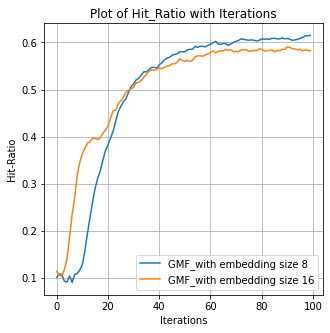

In [34]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(gmf_8_001[0],label="GMF_with embedding size 8")
plt.plot(gmf_16_001[0],label="GMF_with embedding size 16")

plt.xlabel('Iterations')
plt.ylabel('Hit-Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit_Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

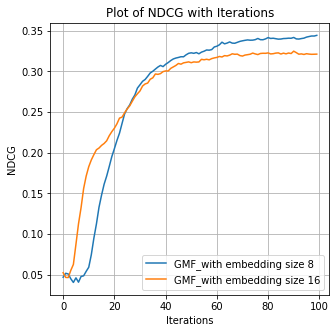

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(gmf_8_001[1],label="GMF_with embedding size 8")
plt.plot(gmf_16_001[1],label="GMF_with embedding size 16")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training Loss')

<Figure size 432x288 with 0 Axes>

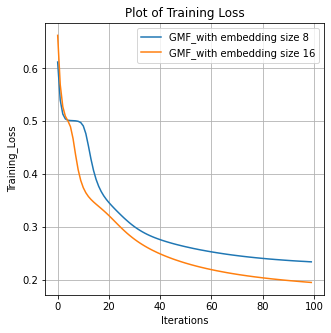

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(gmf_8_001[2],label="GMF_with embedding size 8")
plt.plot(gmf_16_001[2],label="GMF_with embedding size 16")

plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training Loss')

## Plots for Neural Collaborative Filtering model with [16,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit_Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

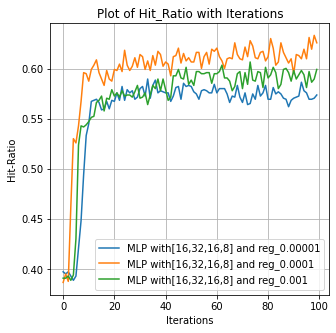

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
mlp_8_arch1_00001
plt.plot(mlp_8_arch1_00001[0],label="MLP with[16,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch1_0001[0],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_001[0],label="MLP with[16,32,16,8] and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('Hit-Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit_Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

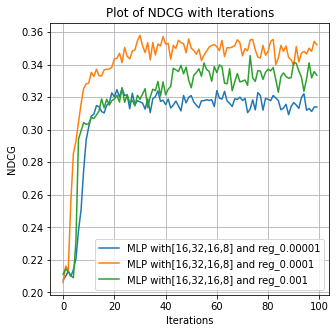

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
mlp_8_arch1_00001
plt.plot(mlp_8_arch1_00001[1],label="MLP with[16,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch1_0001[1],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_001[1],label="MLP with[16,32,16,8] and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training_Loss with Iterations')

<Figure size 432x288 with 0 Axes>

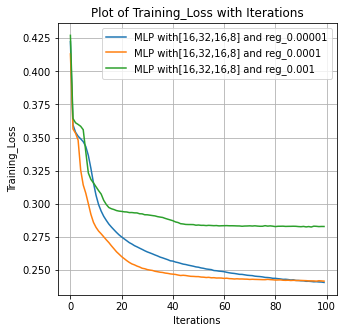

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
mlp_8_arch1_00001
plt.plot(mlp_8_arch1_00001[2],label="MLP with[16,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch1_0001[2],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_001[2],label="MLP with[16,32,16,8] and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training_Loss with Iterations')

## Plots for Neural Collaborative Filtering model with [16,64,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit_Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

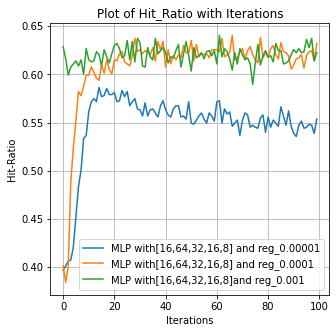

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_00001[0],label="MLP with[16,64,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch2_0001[0],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_001[0],label="MLP with[16,64,32,16,8]and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('Hit-Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit_Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

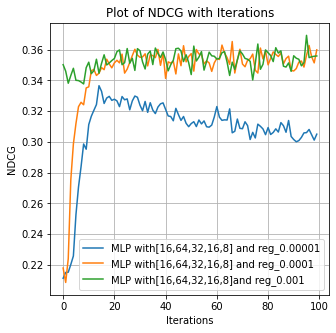

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_00001[1],label="MLP with[16,64,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch2_0001[1],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_001[1],label="MLP with[16,64,32,16,8]and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training_Loss with Iterations')

<Figure size 432x288 with 0 Axes>

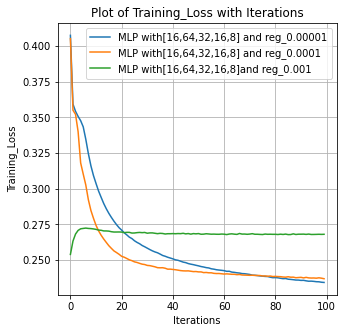

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_00001[2],label="MLP with[16,64,32,16,8] and reg_0.00001")
plt.plot(mlp_8_arch2_0001[2],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_001[2],label="MLP with[16,64,32,16,8]and reg_0.001")
plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training_Loss with Iterations')

## Plots for Neural Collaborative Filtering model with pretrained weights for the architecture [16,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

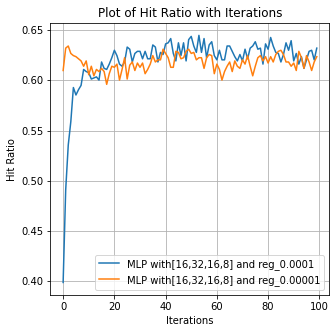

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch1_0001_pretrained[0],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_00001_pretrained[0],label="MLP with[16,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

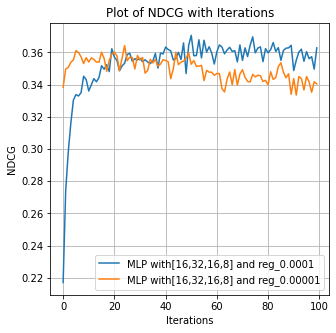

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch1_0001_pretrained[1],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_00001_pretrained[1],label="MLP with[16,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training Loss with Iterations')

<Figure size 432x288 with 0 Axes>

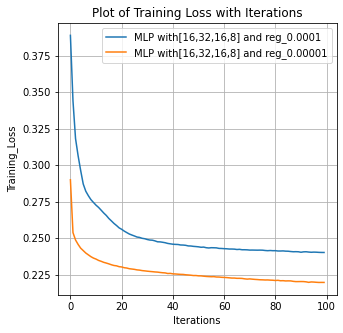

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch1_0001_pretrained[2],label="MLP with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_00001_pretrained[2],label="MLP with[16,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training Loss with Iterations')

## Plots for Neural Collaborative Filtering model with pretrained weights for the architecture [16,64,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

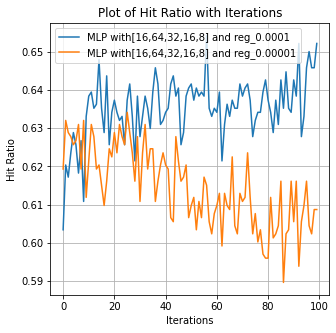

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_0001_pretrained[0],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_00001_pretrained[0],label="MLP with[16,64,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

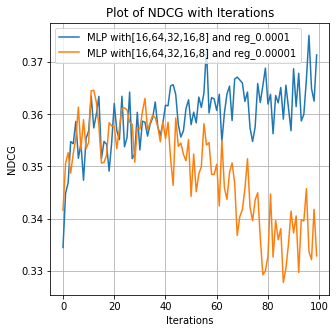

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_0001_pretrained[1],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_00001_pretrained[1],label="MLP with[16,64,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training Loss with Iterations')

<Figure size 432x288 with 0 Axes>

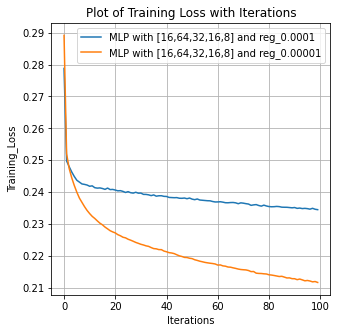

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(mlp_8_arch2_0001_pretrained[2],label="MLP with [16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_00001_pretrained[2],label="MLP with [16,64,32,16,8] and reg_0.00001")
plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training Loss with Iterations')

## Comparison of Pretrained vs Randomly Initialised Neural Collaborative Filtering model for [16,64,32,16,8] and regularisation coefficient 0.0001

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

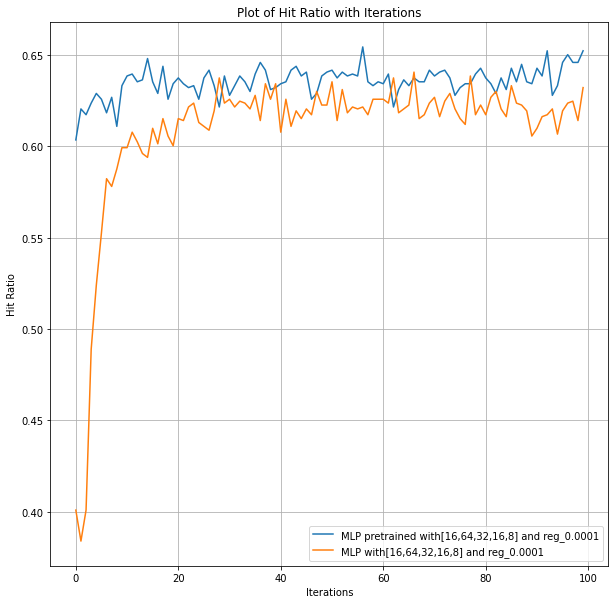

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(mlp_8_arch2_0001_pretrained[0],label="MLP pretrained with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_0001[0],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

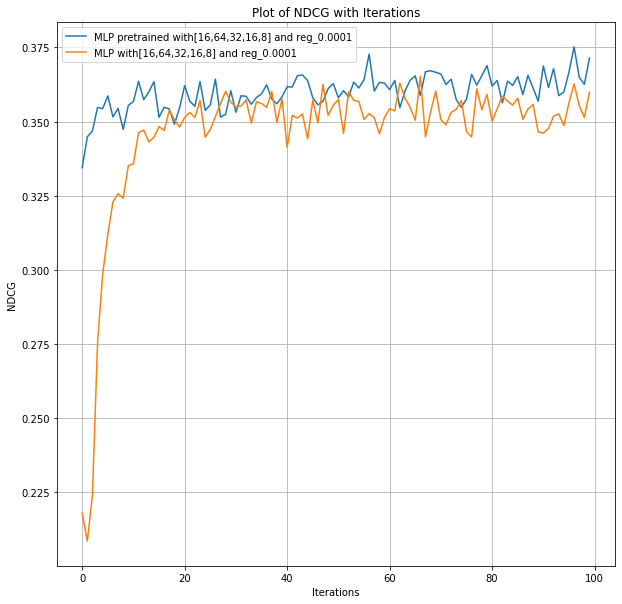

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(mlp_8_arch2_0001_pretrained[1],label="MLP pretrained with[16,64,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch2_0001[1],label="MLP with[16,64,32,16,8] and reg_0.0001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

## Comparison of Pretrained vs Randomly Initialised Neural Collaborative Filtering model for [16,32,16,8] and regularisation coefficient 0.0001

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

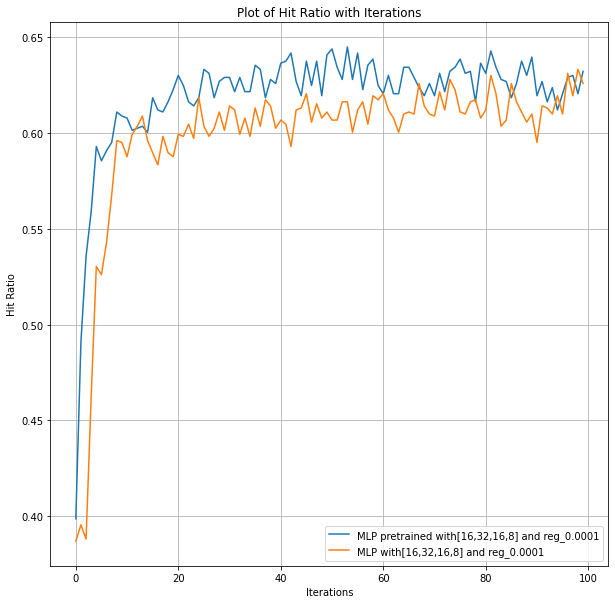

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(mlp_8_arch1_0001_pretrained[0],label="MLP pretrained with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_0001[0],label="MLP with[16,32,16,8] and reg_0.0001")
plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

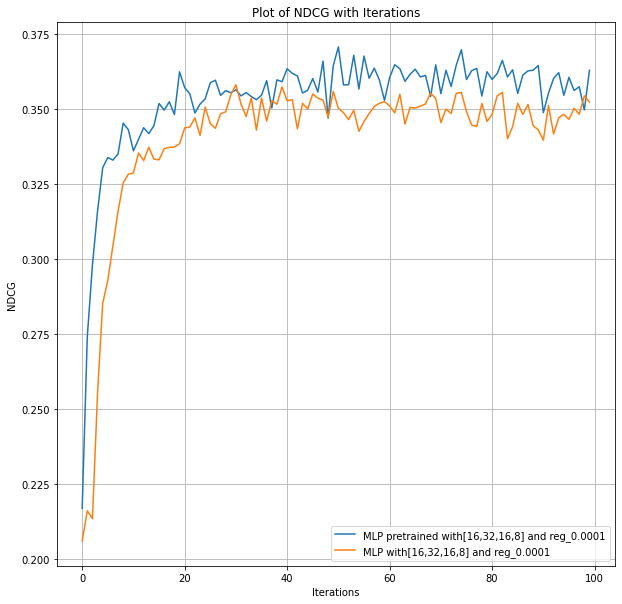

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.plot(mlp_8_arch1_0001_pretrained[1],label="MLP pretrained with[16,32,16,8] and reg_0.0001")
plt.plot(mlp_8_arch1_0001[1],label="MLP with[16,32,16,8] and reg_0.0001")
plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

## Plots of Neural Matrix Factorization Model with random intialization and regularisation coefficient for architecture [16,32,16,8]

Text(0.5, 1.0, 'Plot of Hit_Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

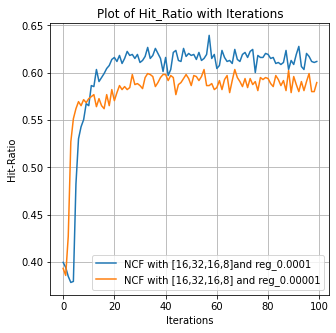

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001[0],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_00001[0],label="NCF with [16,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Hit-Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit_Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

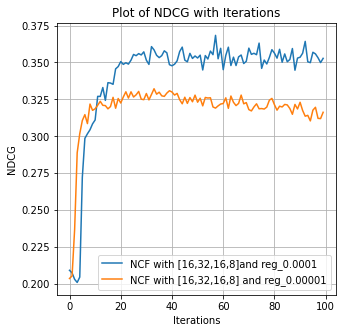

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001[1],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_00001[1],label="NCF with [16,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training_Loss with Iterations')

<Figure size 432x288 with 0 Axes>

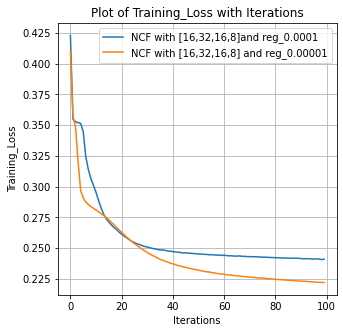

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001[2],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_00001[2],label="NCF with [16,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training_Loss with Iterations')

## Plots of Neural Matrix Factorization Model with random intialization and regularisation coefficient for architecture [16,64,32,16,8]

Text(0.5, 1.0, 'Plot of Hit_Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

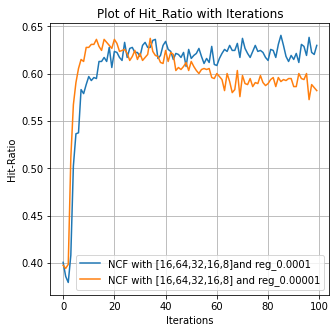

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch2_0001[0],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_00001[0],label="NCF with [16,64,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Hit-Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit_Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

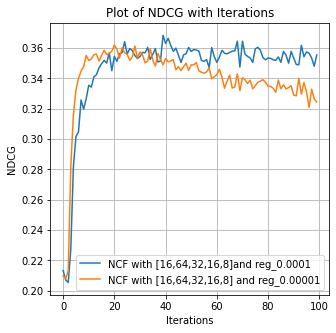

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch2_0001[1],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_00001[1],label="NCF with [16,64,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Training_Loss with Iterations')

<Figure size 432x288 with 0 Axes>

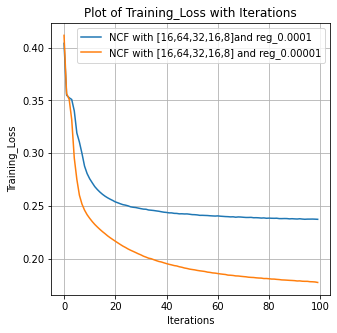

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch2_0001[2],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_00001[2],label="NCF with [16,64,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Training_Loss')
plt.grid()
plt.legend()
plt.title('Plot of Training_Loss with Iterations')

## Plots of Neural Collaborative Filtering model with pretrained weights  from NCF and GMF for the architecture [16,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

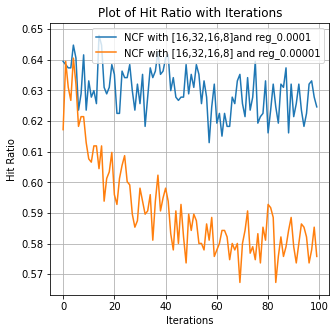

In [35]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001_pretrained[0],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_00001_pretrained[0],label="NCF with [16,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')


Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

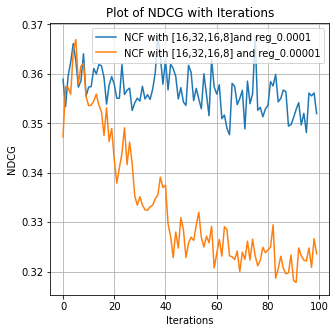

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001_pretrained[1],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_00001_pretrained[1],label="NCF with [16,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

## Plots of Neural Collaborative Filtering model with pretrained weights  from NCF and GMF for the architecture [16,64,32,16,8] and different regularisation coefficient

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

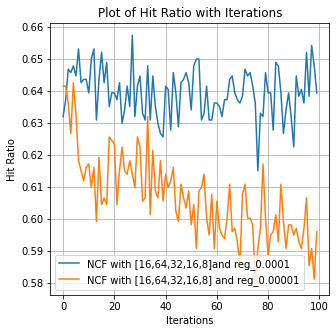

In [36]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch2_0001_pretrained[0],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_00001_pretrained[0],label="NCF with [16,64,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

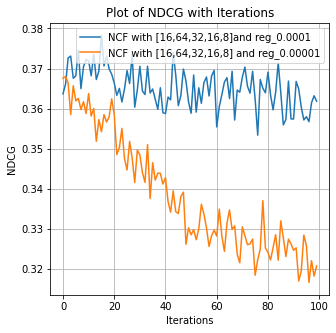

In [37]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch2_0001_pretrained[1],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_00001_pretrained[1],label="NCF with [16,64,32,16,8] and reg_0.00001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

## Comparison of Pretrained vs Randomly Initialised Neural Matrix Factorization model for [16,32,16,8] and regularisation coefficient 0.0001

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

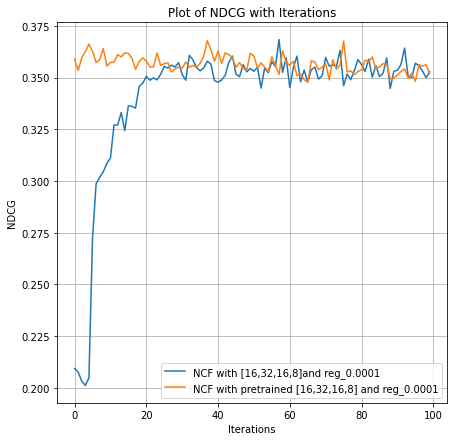

In [46]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch1_0001[1],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_0001_pretrained[1],label="NCF with pretrained [16,32,16,8] and reg_0.0001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

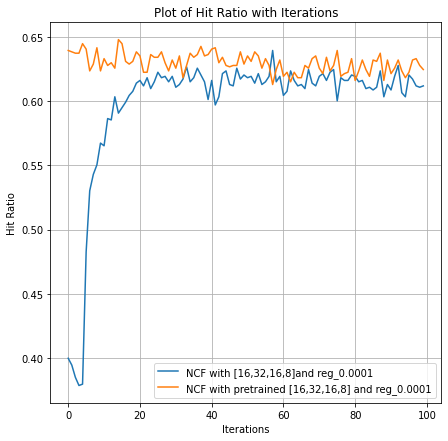

In [43]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch1_0001[0],label="NCF with [16,32,16,8]and reg_0.0001")
plt.plot(ncf_arch1_0001_pretrained[0],label="NCF with pretrained [16,32,16,8] and reg_0.0001")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

## Comparison of Pretrained vs Randomly Initialised Neural Matrix Factorization model for [16,64,32,16,8] and regularisation coefficient 0.0001

Text(0.5, 1.0, 'Plot of NDCG with Iterations')

<Figure size 432x288 with 0 Axes>

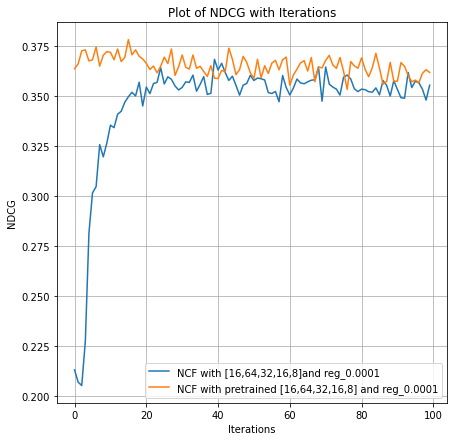

In [44]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch2_0001[1],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_0001_pretrained[1],label="NCF with pretrained [16,64,32,16,8] and reg_0.0001")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Plot of NDCG with Iterations')

Text(0.5, 1.0, 'Plot of Hit Ratio with Iterations')

<Figure size 432x288 with 0 Axes>

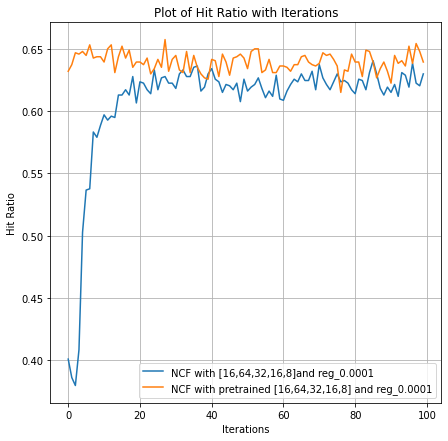

In [45]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch2_0001[0],label="NCF with [16,64,32,16,8]and reg_0.0001")
plt.plot(ncf_arch2_0001_pretrained[0],label="NCF with pretrained [16,64,32,16,8] and reg_0.0001")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Plot of Hit Ratio with Iterations')

## Comparison of NMF vs NCF vs GMF for [16,32,16,8] with regularisation coefficient 0.0001

Text(0.5, 1.0, 'Comparison of Hit-Ratio for NCF vs GMF vs MLP')

<Figure size 432x288 with 0 Axes>

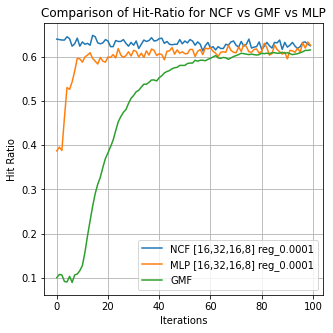

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001_pretrained[0],label="NCF [16,32,16,8] reg_0.0001")
plt.plot(mlp_8_arch1_0001[0],label="MLP [16,32,16,8] reg_0.0001")
plt.plot(gmf_8_001[0],label="GMF")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Comparison of Hit-Ratio for NCF vs GMF vs MLP')

Text(0.5, 1.0, 'Comparison of NDCG for NCF vs GMF vs MLP')

<Figure size 432x288 with 0 Axes>

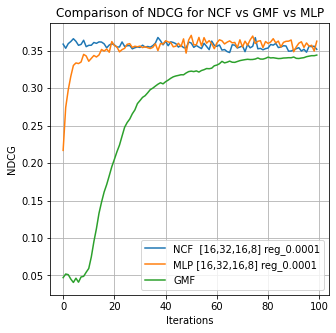

In [ ]:
plt.figure()
plt.figure(figsize=(5,5))
plt.plot(ncf_arch1_0001_pretrained[1],label="NCF  [16,32,16,8] reg_0.0001")
plt.plot(mlp_8_arch1_0001_pretrained[1],label="MLP [16,32,16,8] reg_0.0001")
plt.plot(gmf_8_001[1],label="GMF")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Comparison of NDCG for NCF vs GMF vs MLP')

## Comparison of NMF vs NCF vs GMF for [16,64,32,16,8] with regularisation coefficient 0.0001

Text(0.5, 1.0, 'Comparison of Hit-Ratio for NCF vs GMF vs MLP')

<Figure size 432x288 with 0 Axes>

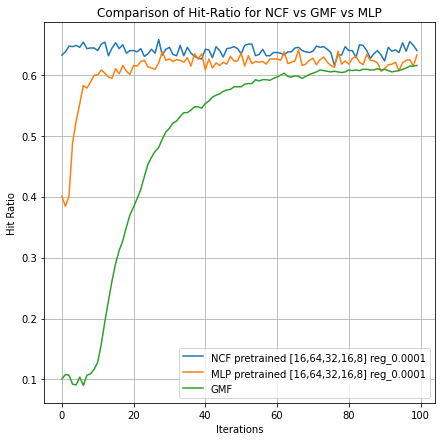

In [ ]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch2_0001_pretrained[0],label="NCF [16,64,32,16,8] reg_0.0001")
plt.plot(mlp_8_arch2_0001[0],label="MLP [16,64,32,16,8] reg_0.0001")
plt.plot(gmf_8_001[0],label="GMF")

plt.xlabel('Iterations')
plt.ylabel('Hit Ratio')
plt.grid()
plt.legend()
plt.title('Comparison of Hit-Ratio for NCF vs GMF vs MLP')

Text(0.5, 1.0, 'Comparison of NDCG for NCF vs GMF vs MLP')

<Figure size 432x288 with 0 Axes>

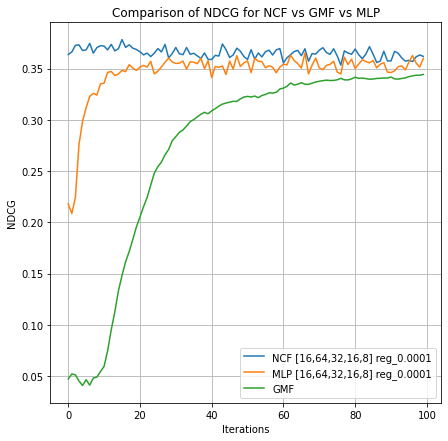

In [ ]:
plt.figure()
plt.figure(figsize=(7,7))
plt.plot(ncf_arch2_0001_pretrained[1],label="NCF [16,64,32,16,8] reg_0.0001")
plt.plot(mlp_8_arch2_0001[1],label="MLP [16,64,32,16,8] reg_0.0001")
plt.plot(gmf_8_001[1],label="GMF")

plt.xlabel('Iterations')
plt.ylabel('NDCG')
plt.grid()
plt.legend()
plt.title('Comparison of NDCG for NCF vs GMF vs MLP')